In [3]:
from cycler import cycler
from os import listdir, stat
from os.path import isfile, join

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import numpy as np


In [4]:
%matplotlib inline
# plt.ion()
# sns.set_palette('Set3')
# plt.style.use('Solarize_Light2')
color1 = cycler('color', ['c', 'k', 'r', 'g', 'b', 'y'])
linestyle1 = cycler('ls', ['-', '--', ':', '-.'])
c1 = color1 * linestyle1
c2 = linestyle1 * color1
plt.rc('axes', prop_cycle=c2)


def filterr(df, col, val):
    return df[df[col] == val].reset_index(drop=True)


def filterrnot(df, col, val):
    return df[df[col] != val].reset_index(drop=True)


def filterrnz(df, col):
    return filterrnot(df, col, 0)


def plot_line(xs, ys, label, color=None, marker=None, ax=None):
    if ax is None:
        ax = plt
    return ax.plot(xs, ys, label=label, color=color, marker=marker)


def setup_plot(title, xlabel, ylabel, ax=None, xscale='linear', xbase=10, yscale='linear', ybase=10):
    if ax is not None:
        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        if xscale != 'linear':
            ax.set_xscale(xscale, base=xbase)
        if yscale != 'linear':
            ax.set_yscale(yscale, base=ybase)
        return

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if xscale != 'linear':
        plt.xscale(xscale, base=xbase)
    if yscale != 'linear':
        plt.yscale(yscale, base=ybase)


def grouped_bars(df, group_name, title, yname):
    bars_per_group = len(df.columns) - 1
    x = np.arange(len(df))
    width = 1 / (bars_per_group+1)

    offset_mult = 0
    fig, ax = plt.subplots(layout='constrained')

    for col in filter(lambda x: x != group_name, df.columns):
        offset = width * offset_mult
        rects = ax.bar(x + offset, df[col], width, label=col)
        ax.bar_label(rects, padding=3)
        offset_mult += 1

    ax.set_title(title)
    ax.set_ylabel(yname)
    ax.set_xticks(x + width, df[group_name])
    ax.legend()
    plt.show()


def graph_by(df, col1, col2, xname, yname, sharey=True, omap=None):
    col1_vals = sorted(list(set(df[col1])), reverse=True)
    nplots = len(col1_vals)

    yscale = 'log'
    ybase = 10
    xscale = 'log'
    xbase = 2

    fig, axs = plt.subplots(nplots, sharex=False,
                            sharey=sharey, figsize=(8, (3*nplots)+1))
    plt.subplots_adjust(hspace=.45)
    # all_ymin, all_ymax = None, None

    for cnt, v1 in enumerate(col1_vals):
        ax = axs[cnt] if nplots > 1 else axs
        ax.grid()
        setup_plot(f'{yname} ({col1.replace("lf", "L")}={v1})', xname, 'time (s)', ax=ax,
                   xscale=xscale, xbase=xbase, yscale=yscale, ybase=ybase)

        dv1 = filterr(df, col1, v1)
        if omap is not None:
            omap_max_n = omap['n'].max()
            omap_ins_time = list(set(filterr(omap, 'n', omap_max_n)[yname]))[0]
            omapx = np.asarray(sorted(list(set(filterrnz(dv1, xname)[xname]))))
            omapy = (omapx * omap_ins_time)
            plot_line(omapx, omapy, 'OMap', ax=ax)

        col2_vals = sorted(list(set(dv1[col2])))
        for v2 in col2_vals:
            dv1v2 = filterr(dv1, col2, v2)
            d = filterrnz(dv1v2, xname)
            d = filterrnz(d, yname)
            d.sort_values([xname], ascending=True, inplace=True)
            x = d[xname]
            y = d[yname]
            plot_line(x, y, f'{col2.replace("lf", "L")}={v2}',
                      marker='+', ax=ax)

        ymin, ymax = ax.get_ylim()

        if xname == 'vl' and (col1 == 's' or col2 == 's'):
            s = v1 if col1 == 's' else v2
            assert len(set(d['n'])) == 1
            n = list(set(d['n']))[0]
            l = round(np.log2(n))
            p = (l+1) // s
            levels = list(range(l - ((s-1) * p), l+1, p))
            ax.vlines(2 ** np.asarray(levels),
                      ymin=ymin, ymax=ymax,
                      color='purple', linestyle=':', label='level')

    # plt.ylim(all_ymin, all_ymax)
    labels_handles = {
        label: handle
        for ax in (axs if nplots > 1 else [axs])
        for handle, label in zip(*ax.get_legend_handles_labels())
    }
    labels = labels_handles.keys()
    handles = labels_handles.values()

    leg = fig.legend(
        handles,
        labels,
        loc="upper right",
        bbox_to_anchor=(0.05, 0.5),
        bbox_transform=plt.gcf().transFigure,
    )
    # leg_lines = leg.get_lines()
    # leg_texts = leg.get_texts()
    # plt.setp(leg_lines, linewidth=6)
    plt.show()


In [5]:
allofs = pd.read_csv('data/ofs.csv')
allofsappend = pd.read_csv('data/ofs-append.csv')
allomap = pd.read_csv('data/omap.csv')

In [6]:
ofs_sm = filterr(
    filterr(filterr(allofs, 'data_mem', 0), 'aux_mem', 1), 'ssd', 1)
ofs_ss = filterr(
    filterr(filterr(allofs, 'data_mem', 0), 'aux_mem', 0), 'ssd', 1)
ofs_hm = filterr(
    filterr(filterr(allofs, 'data_mem', 0), 'aux_mem', 1), 'ssd', 0)
ofs_hh = filterr(
    filterr(filterr(allofs, 'data_mem', 0), 'aux_mem', 0), 'ssd', 0)
ofs_mm = filterr(
    filterr(filterr(allofs, 'data_mem', 1), 'aux_mem', 1), 'ssd', 0)

ofs = [
    ofs_sm,
    ofs_ss,
    ofs_hm,
    ofs_hh,
    ofs_mm,
]

app_sm = filterr(
    filterr(filterr(allofsappend, 'data_mem', 0), 'aux_mem', 1), 'ssd', 1)
app_ss = filterr(
    filterr(filterr(allofsappend, 'data_mem', 0), 'aux_mem', 0), 'ssd', 1)
app_hm = filterr(
    filterr(filterr(allofsappend, 'data_mem', 0), 'aux_mem', 1), 'ssd', 0)
app_hh = filterr(
    filterr(filterr(allofsappend, 'data_mem', 0), 'aux_mem', 0), 'ssd', 0)
app_mm = filterr(
    filterr(filterr(allofsappend, 'data_mem', 1), 'aux_mem', 1), 'ssd', 0)

app = [
    app_sm,
    app_ss,
    app_hm,
    app_hh,
    app_mm,
]

# for iapp in app:
#     iapp['vl'] += 1

omp_sm = filterr(
    filterr(filterr(allomap, 'data_mem', 0), 'aux_mem', 1), 'ssd', 1)
omp_ss = filterr(
    filterr(filterr(allomap, 'data_mem', 0), 'aux_mem', 0), 'ssd', 1)
omp_hm = filterr(
    filterr(filterr(allomap, 'data_mem', 0), 'aux_mem', 1), 'ssd', 0)
omp_hh = filterr(
    filterr(filterr(allomap, 'data_mem', 0), 'aux_mem', 0), 'ssd', 0)
omp_mm = filterr(
    filterr(filterr(allomap, 'data_mem', 1), 'aux_mem', 1), 'ssd', 0)

omp = [
    omp_sm,
    omp_ss,
    omp_hm,
    omp_hh,
    omp_mm,
]

sm = ('ssd-mem', ofs_sm, app_sm, omp_sm)
ss = ('ssd-only', ofs_ss, app_ss, omp_ss)
hm = ('hdd-mem', ofs_hm, app_hm, omp_hm)
hh = ('hdd-only', ofs_hh, app_hh, omp_hh)
mm = ('mem-only', ofs_mm, app_mm, omp_mm)

groups = [
    sm,
    ss,
    hm,
    hh,
    mm,
]

names = [group[0] for group in groups]

OFS[hdd-mem]: 128


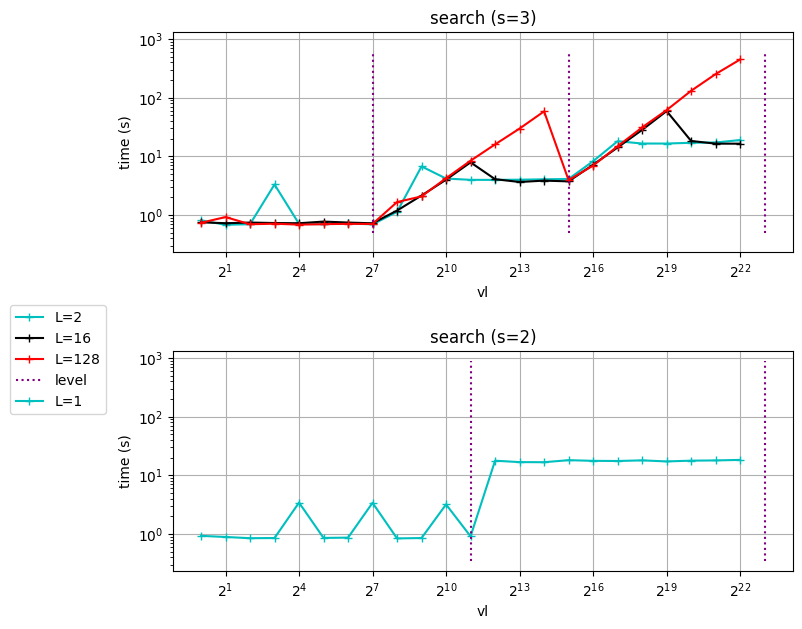

OFS[hdd-mem]: 32


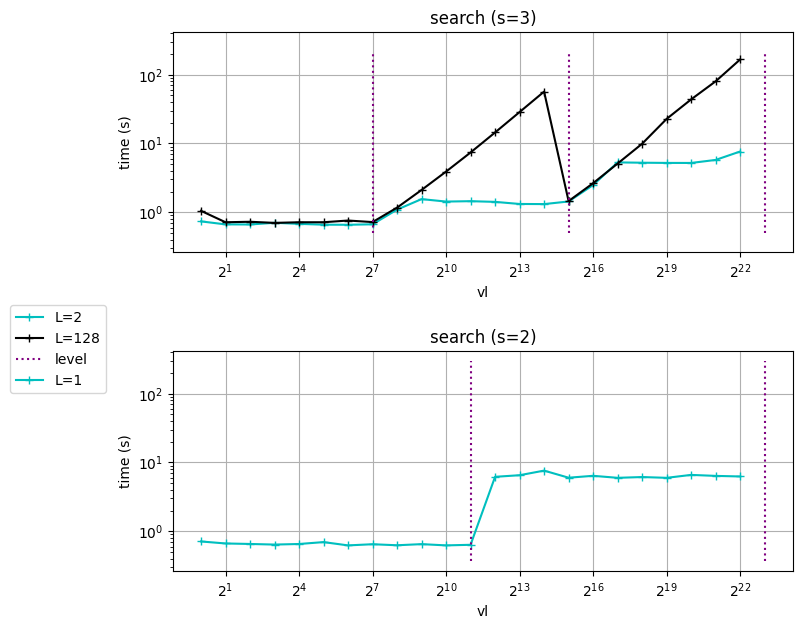

OFS[hdd-only]: 128


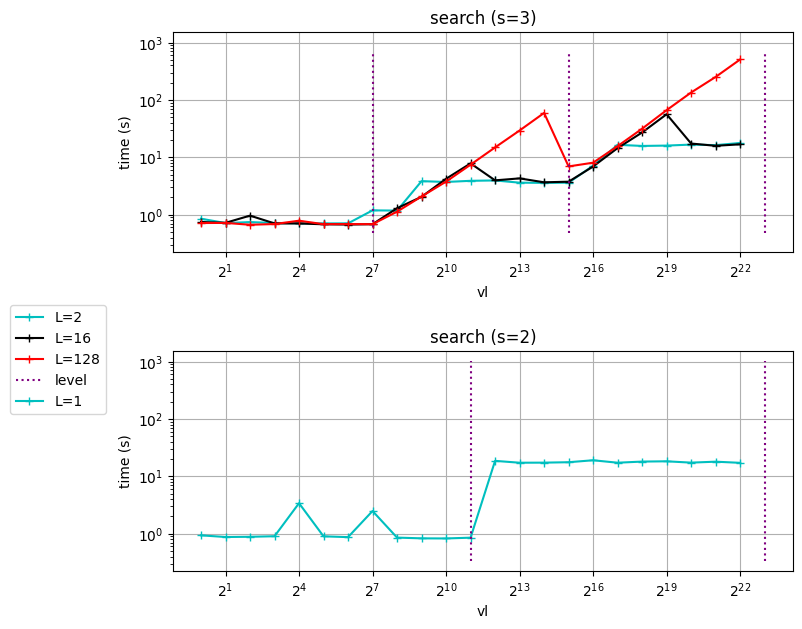

OFS[hdd-only]: 32


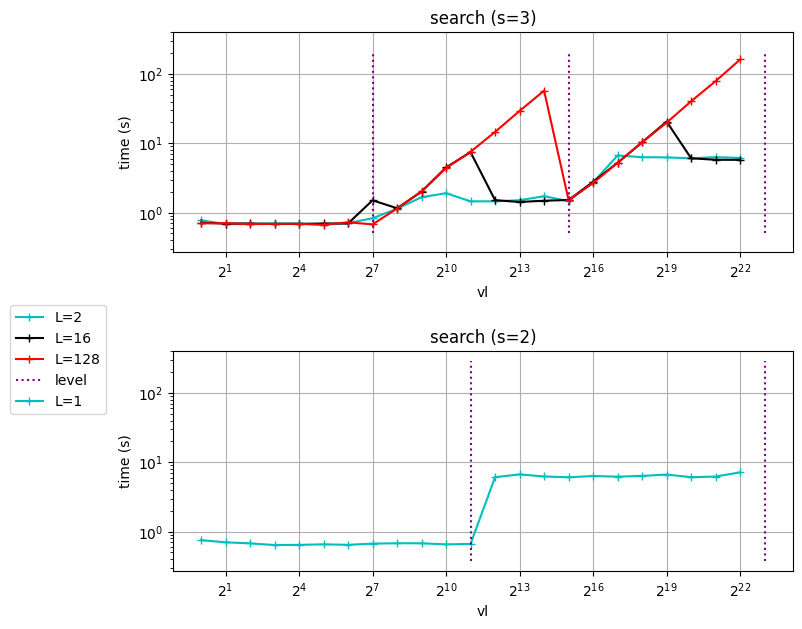

In [7]:
for idx, iofs in enumerate(ofs):
    vls = list(set(iofs['bbs']))
    for vl in vls:
        print(f'OFS[{names[idx]}]: {vl}')
        ds = filterr(iofs, 'bbs', vl)
        graph_by(ds, 's', 'lf', 'vl', 'search')

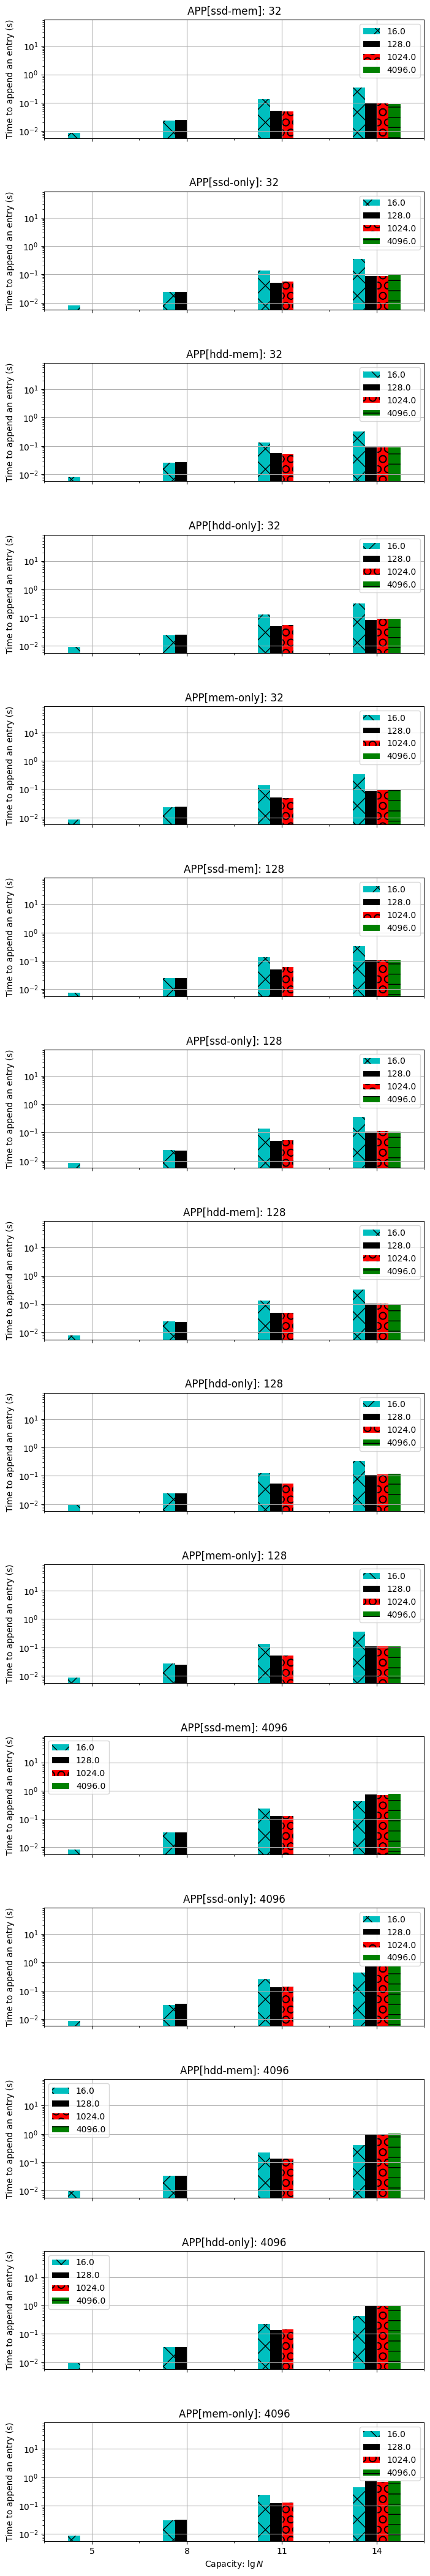

In [8]:
vls = sorted(list(set([x for xapp in app for x in set(xapp['bbs'])])))
nplots = sum([len(set(x['bbs'])) for x in app])
fig, axs = plt.subplots(
    nplots,
    sharex=True, sharey=True,
    figsize=(8, (3.5*nplots)+1)
)

ax_idx = 0
for vl in vls:
    for idx, iapp in enumerate(app):
        ax = axs[ax_idx]
        ax_idx += 1

        ds = (
            filterr(iapp, 'bbs', vl)
            [['vl', 'n', 'append']]
            .sort_values(by=['n', 'vl'])
            .rename(columns={'vl': 'Block Size'})
        )
        ds['n'] = np.log2(ds['n']).astype(np.integer)
        ds = (
            ds
            .pivot(index='n', columns='Block Size', values='append')
            .drop(columns=0.0)
        )

        ds.plot(ax=ax, kind='bar', bottom=0, legend=False, logy=True, rot=0)
        bars = ax.patches
        hatches = ''.join(h*len(ds) for h in 'x+O-')
        for bar, hatch in zip(bars, hatches):
            bar.set_hatch(hatch)
        ax.legend()
        ax.set_xlabel('Capacity: $\lg N$')
        ax.set_ylabel('Time to append an entry (s)')
        ax.set_title(f'APP[{names[idx]}]: {vl}')
        ax.grid()
        # ax.set_xscale('log', base=2)
        # ax.set_yscale('log')

plt.subplots_adjust(hspace=.45)
plt.legend()
plt.show()